<img src='https://www.met.no/om-oss/logo/_/image/73f29cde-219f-487b-809c-9cdd61032c78:2efc46ce776f5f5337c4b0156ae0cbaa3b6bf6fe/width-768/Met_RGB_Horisontal.jpg' width=200 align=right>
<img src='https://raw.githubusercontent.com/norkyst/norkyst-logo/refs/heads/main/png/horizontal_35_91_100.png' width=200 align=right>

# __UNDER CONSTRUCTION__

# Vertical cross-sections using Norkyst v3 data

This notebook will give instructions, tips and tricks on how to access data from MET's THREDDS server and how to visualize it. The main focus will be plotting vertical cross sections and making streamplots using the new operational Norkyst v3. 

The goal is a vertical cross-section with the bottom topography shown, filled contour of a 3D-variable with distance on the x-axis and depth on the y-axis. The section will be determined by two arbitrary positions in latitude/longitude, inside the model domain. 

__Python requirements__:

To access data from the model and extracting it into datasets we will make use of some Python packages.

Xarray will be the main tool to opening the datasets, and allows us to display the contents nicely. Cartopy and matplotlib are the main plotting tools, in addition to Cmocean for colormaps. 

If you are unfamiliar with these packages or need help, please see the documentations listed below.

**Useful documentation**:

* Cartopy: https://scitools.org.uk/cartopy/docs/latest/
* Cmocean: https://matplotlib.org/cmocean/
* Matplotlib: https://matplotlib.org/stable/
* NumPy: https://numpy.org/doc/
* Xarray:https://docs.xarray.dev/en/stable/

In [1]:
# Importing useful python libraries

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmocean
import xroms
import netCDF4
import roppy

### Accessing the data

Data can be found at https://thredds.met.no/thredds/catalog.html.
Locate project, folder and files. Here we will use OPENDAP url to read in the data.
To get the OPENDAP URL, click on the desired NetCDF file (.nc). Under the "ACCESS" section, select the OPENDAP URL and then copy the URL located under "DATA URL".

In [8]:
# Reading in the path from thredds.met.no, using an OPENDAP url
path = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkystv3_his_files/2025/08/11/norkyst800_his_zdepth_latest_m00_FC_0004.nc'

# Opening a netCDF file as xarray dataset
ds = xr.open_dataset(path)

# Viewing the dataset
ds

<xarray.Dataset>
Dimensions:                  (time: 24, X: 2747, Y: 1148, depth: 15)
Coordinates:
  * time                     (time) datetime64[ns] 2025-08-15 ... 2025-08-15T...
  * X                        (X) int32 0 800 1600 ... 2195200 2196000 2196800
  * Y                        (Y) int32 0 800 1600 2400 ... 916000 916800 917600
  * depth                    (depth) float64 0.0 1.0 2.0 ... 100.0 200.0 300.0
    lon                      (Y, X) float64 ...
    lat                      (Y, X) float64 ...
Data variables:
    projection_stere         int32 ...
    forecast_reference_time  datetime64[ns] ...
    h                        (Y, X) float64 ...
    zeta                     (time, Y, X) float32 ...
    u_eastward               (time, depth, Y, X) float32 ...
    v_northward              (time, depth, Y, X) float32 ...
    w                        (time, depth, Y, X) float32 ...
    temperature              (time, depth, Y, X) float32 ...
    salinity                 (time, depth, Y, X) float32 ...
    AKs                      (time, depth, Y, X) float32 ...
    Uwind_eastward           (time, Y, X) float32 ...
    Vwind_northward          (time, Y, X) float32 ...
Attributes: (12/41)
    id:                              4c453da7-51f0-493c-8b76-ab622b656be5
    naming_authority:                no.met
    operational_status:              Operational
    iso_topic_category:              oceans
    activity_type:                   Numerical Simulation
    keywords_vocabulary:             GCMDSK:GCMD Science Keywords:https://gcm...
    ...                              ...
    title_no:                        120 timers prognoser fra havmodellen Nor...
    summary_no:                      NorKyst_v3-800m (Norske kystområder med ...
    contributor_name:                Magne Simonsen, Mateusz Matuszak
    contributor_role:                Technical contact, Metadata author
    contributor_email:               magnes@met.no, mateuszm@met.no
    DODS_EXTRA.Unlimited_Dimension:  time

In the drop-down menu above you have an overview of the chosen dataset.

In [9]:
# Selecting a timestep to work with
timestamp = ds.time[0]
ds = ds.isel(time=0)

In [6]:
# The transect we will be working with
lat_sec = np.array([59.04, 57.79]) # start_lat, end_lat
lon_sec = np.array([10.62, 10.56])  # start_lon, end_lon

In [16]:
# Latitude and longitude of the dataset
lat = ds.lat.values
lon = ds.lon.values

We can start by showing the chosen transect on a map.

Text(0.5, 1.0, 'Sea surface height at 2025-08-15T00:00:00.000000000')

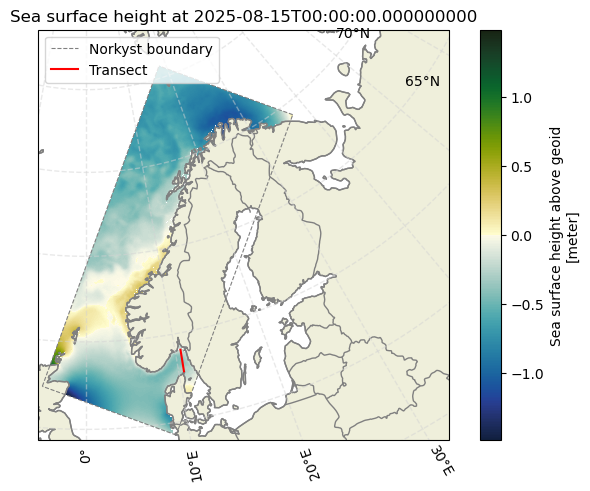

In [17]:
# Choosing a map projection
proj = ccrs.NorthPolarStereo()

# Making figure and axes with the projection
fig, ax = plt.subplots(subplot_kw={'projection': proj}, constrained_layout=True)

# Setting the extent of the map to our model domain
ax.set_extent([np.min(lon), np.max(lon), np.min(lat), np.max(lat)], crs=ccrs.PlateCarree())  # ccrs.PlateCarree() to tell the program our data is in coordinates lats/lons

# Adding natural features to our map
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', edgecolor='gray', facecolor=cfeature.COLORS['land'])
coastline = cfeature.NaturalEarthFeature(category='physical', name='coastline', scale='50m', edgecolor='gray', facecolor='none')
borders = cfeature.NaturalEarthFeature(category='cultural', name='admin_0_boundary_lines_land', edgecolor= 'gray', scale='50m', facecolor='none')

ax.add_feature(land)
ax.add_feature(coastline)
ax.add_feature(borders)

# Adding gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='lightgray', alpha=0.5, linestyle='--')
gl.top_labels = False  # Disable top labels
gl.right_labels = False  # Disable right labels
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Plotting boundaries of model
ax.plot(lon[0,:], lat[0,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)
ax.plot(lon[-1,:], lat[-1,:], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)  
ax.plot(lon[:,0], lat[:,0], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8)
ax.plot(lon[:,-1], lat[:,-1], '--', transform= ccrs.PlateCarree(), color = 'gray', linewidth =0.8, label='Norkyst boundary')

# Plotting sea surface height
ds.zeta.plot(ax = ax, x = 'lon', y = 'lat', transform = ccrs.PlateCarree(), cmap=cmocean.cm.delta)

# Adding transect
ax.plot([lon_sec[0], lon_sec[1]], [lat_sec[0], lat_sec[1]], transform = ccrs.PlateCarree(), color = 'r', label = 'Transect')

# Adding legend
ax.legend(loc = 'upper left')

# Adding title
ax.set_title(f'Sea surface height at {timestamp.values}')

In [35]:
# Finding indices of the transect
y_0, x_0 = xroms.argsel2d(lon, lat, lon_sec[1], lat_sec[1])
y_1, x_1 = xroms.argsel2d(lon, lat, lon_sec[0], lat_sec[0])

In [36]:
# Checking to see that the indices match the wanted transect

print(f'Wanted start of transect: {lon_sec[1]}, {lat_sec[1]}')
print(f'Corresponding coordinates in dataset: {lon[y_0, x_0]:.2f}, {lat[y_0, x_0]:.2f}')

print(f'Wanted end of transect: {lon_sec[0]}, {lat_sec[0]}')
print(f'Corresponding coordinates in dataset: {lon[y_1, x_1]:.2f}, {lat[y_1, x_1]:.2f}')

Wanted start of transect: 10.56, 57.79
Corresponding coordinates in dataset: 10.56, 57.79
Wanted end of transect: 10.62, 59.04
Corresponding coordinates in dataset: 10.63, 59.04


In [37]:
ds.temperature[:, y_0:y_1, x_0:x_1]

<xarray.DataArray 'temperature' (depth: 15, Y: 85, X: 154)>
[196350 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2025-08-15
  * X        (X) int32 403200 404000 404800 405600 ... 524000 524800 525600
  * Y        (Y) int32 93600 94400 95200 96000 ... 158400 159200 160000 160800
  * depth    (depth) float64 0.0 1.0 2.0 3.0 5.0 ... 65.0 75.0 100.0 200.0 300.0
    lon      (Y, X) float64 10.56 10.56 10.57 10.58 ... 10.61 10.62 10.62 10.63
    lat      (Y, X) float64 57.79 57.79 57.8 57.81 ... 59.01 59.02 59.03 59.03
Attributes:
    units:          Celsius
    grid:           grid
    location:       face
    field:          temperature, scalar, series
    grid_mapping:   projection_stere
    long_name:      Sea water potential temperature
    standard_name:  sea_water_potential_temperature
    time:           time
    minmax:         -2 25
    _ChunkSizes:    [   1    1   24 2747]

(array([27295.,  8159.,  3399.,  3216.,  4519.,  4969., 23459., 58259.,
        15993.,  5221.]),
 array([ 7.44499969,  8.72929955, 10.0135994 , 11.2979002 , 12.58220005,
        13.8664999 , 15.15079975, 16.43510056, 17.71940041, 19.00370026,
        20.28800011]),
 <BarContainer object of 10 artists>)

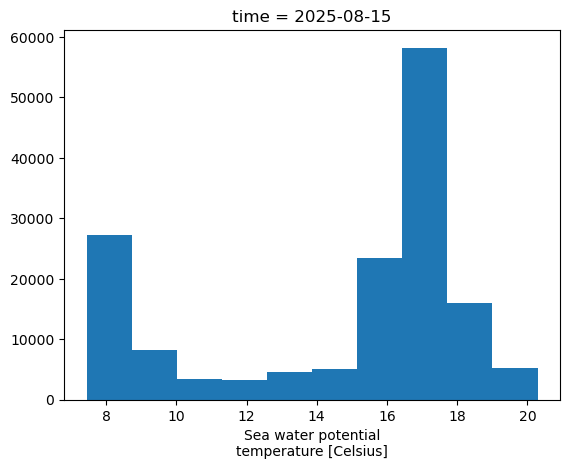

In [47]:
ds.temperature[:, y_0:y_1, x_0:x_1].plot()
#plt.ylim(plt.ylim()[::-1])  # Revert the vertical axis

Issue: have previously made cross sections using Roppy and Sgrid functions, but that was on S-layers. Same functions does not work on z-depth files.

Need to make a linear section and resample variables onto the section.